# dependencies

In [23]:
import pandas as pd

# creating df

In [24]:
df = pd.read_csv("cyberpunk_2077_filtered.csv")
df.head()

,language,review,updated,voted_up,votes_up,votes_funny,steam_purchase,playtime_at_review
0,english,It's very fun. I don't usually like open world...,2023-12-13,True,0,0,True,2452
1,french,loved it before 2.0\n\n\n\n\ndon't like it any...,2023-12-13,False,0,0,False,3349
2,schinese,真的值得体验一下,2023-12-13,True,0,0,True,2116
3,english,Fun game,2023-12-13,True,0,0,True,10324
4,english,cyberpunk,2023-12-13,True,0,0,True,1580


In [25]:
# remove extreme values in playtime_at_review
df = df[df["playtime_at_review"] < 20000]

In [26]:
df["voted_up"] = df["voted_up"].astype(int)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 605914 entries, 0 to 612379
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   language            605914 non-null  object
 1   review              605914 non-null  object
 2   updated             605914 non-null  object
 3   voted_up            605914 non-null  int32 
 4   votes_up            605914 non-null  int64 
 5   votes_funny         605914 non-null  int64 
 6   steam_purchase      605914 non-null  bool  
 7   playtime_at_review  605914 non-null  int64 
dtypes: bool(1), int32(1), int64(3), object(3)
memory usage: 35.2+ MB


# parsing data

In [28]:
# converting the "updated" column to datetime

df["updated"] = pd.to_datetime(df["updated"])
df.head()

,language,review,updated,voted_up,votes_up,votes_funny,steam_purchase,playtime_at_review
0,english,It's very fun. I don't usually like open world...,2023-12-13,1,0,0,True,2452
1,french,loved it before 2.0\n\n\n\n\ndon't like it any...,2023-12-13,0,0,0,False,3349
2,schinese,真的值得体验一下,2023-12-13,1,0,0,True,2116
3,english,Fun game,2023-12-13,1,0,0,True,10324
4,english,cyberpunk,2023-12-13,1,0,0,True,1580


# data exploration

In [29]:
print(df["updated"].min())
print(df["updated"].max())

2020-12-10 00:00:00
2023-12-13 00:00:00


<Axes: xlabel='updated,updated'>

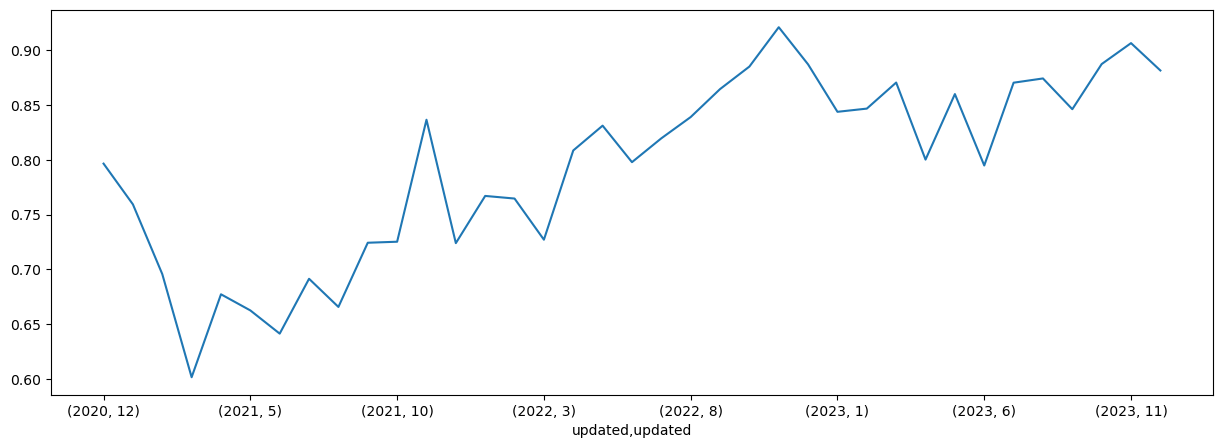

In [30]:
upvote_rate = df.groupby([df['updated'].dt.year, df['updated'].dt.month])["voted_up"].mean()
upvote_rate.plot(kind="line", figsize=(15, 5))

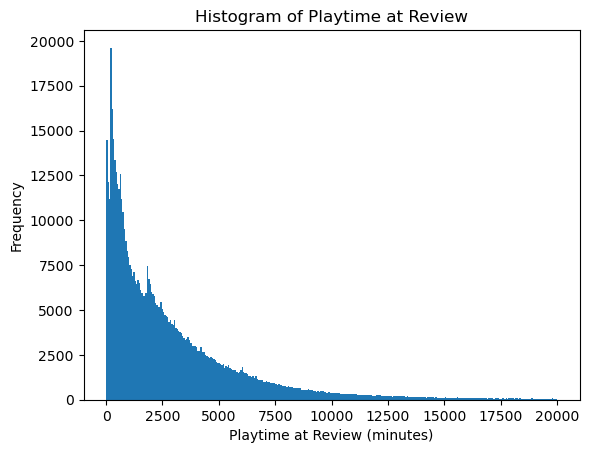

In [31]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(df['playtime_at_review'], bins=int(df['playtime_at_review'].max() / 60))

# Add labels and title
plt.xlabel('Playtime at Review (minutes)')
plt.ylabel('Frequency')
plt.title('Histogram of Playtime at Review')

# Show the histogram
plt.show()


*for the tests, our alpha will be 0.05*

# hypothesis 1: the longer the playtime, the more likely the review is positive


*HO:* longer playtime does not affect the voted up rate

*HA:* longer playtime affects the voted up rate

In [32]:
# performing logistic regression

import statsmodels.api as sm

#logit_model = sm.Logit(df_cpy["voted_up"], df_cpy[['intercept', 'playtime_at_review']])
df["intercept"] = 1
print(df[["playtime_at_review", "intercept"]].shape)
logit_model = sm.Logit(df["voted_up"], df[["playtime_at_review", "intercept"]])
result = logit_model.fit()

print(result.summary())

(605914, 2)
Optimization terminated successfully.
         Current function value: 0.488048
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               voted_up   No. Observations:               605914
Model:                          Logit   Df Residuals:                   605912
Method:                           MLE   Df Model:                            1
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                 0.01346
Time:                        23:28:30   Log-Likelihood:            -2.9571e+05
converged:                       True   LL-Null:                   -2.9975e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
playtime_at_review     0.0001   1.31e-06     82.477      0.000       0.000      

since the coefficient of playtime_at_review of 0.00 is less than 0.05, we can reject the null hypothesis. Therefore, the longer the playtime, the more likely the review is positive.

C:\Users\Dahong Luo\AppData\Local\Temp\ipykernel_124532\902095910.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(bins)['voted_up'].mean()


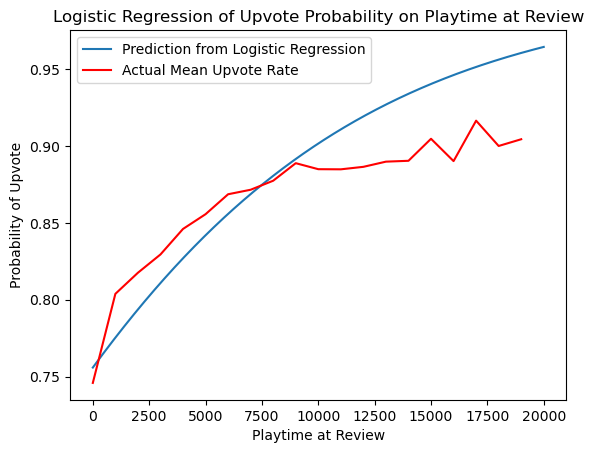

In [33]:
import numpy as np
#drop very high values because the graph will look bad otherwise because of the one guy with no life who played the game for 831446 minutes (13857 hours) and other no life people
playtime_range = np.arange(0, df['playtime_at_review'].max() + 1, 1)
probabilities = result.predict(np.array([playtime_range,np.ones(playtime_range.shape)]).T)
plt.plot(playtime_range, probabilities)

bins = pd.cut(df['playtime_at_review'], bins=range(0, df['playtime_at_review'].max()+1000, 1000))
grouped_df = df.groupby(bins)['voted_up'].mean()
plt.plot(np.arange(0, df['playtime_at_review'].max(), 1000), grouped_df, color='red')


plt.xlabel('Playtime at Review')
plt.ylabel('Probability of Upvote')
plt.legend(['Prediction from Logistic Regression', 'Actual Mean Upvote Rate'])
plt.title('Logistic Regression of Upvote Probability on Playtime at Review')
plt.show()

# hypothesis 2: Those who did not buy the game on steam are most likely trolls and will not vote up


*HO:* buying the game on steam does not affect the voted up rate

*HA:* buying the game on steam affects the voted up rate

In [34]:
from scipy.stats import chi2, chi2_contingency
contingency = pd.crosstab(df["voted_up"], df["steam_purchase"])
result = chi2_contingency(contingency)
print(result)

Chi2ContingencyResult(statistic=1900.172341977036, pvalue=0.0, dof=1, expected_freq=array([[ 12564.41594022, 106150.58405978],
       [ 51563.58405978, 435635.41594022]]))


The statistic is a really high number at 1909.9350521045753 and the p-value is 0.0, so we can reject the null hypothesis since it is less than 0.05. This is a strong evidence that online trolls literally just voted down the game without even buying it.

<Axes: xlabel='steam_purchase', ylabel='voted_up'>

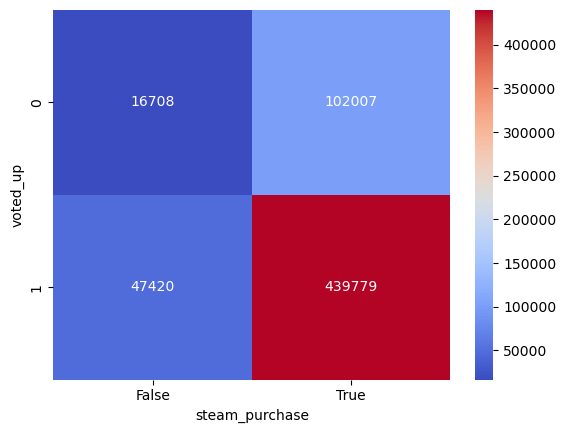

In [35]:
import seaborn as sns

sns.heatmap(contingency, annot=True, cmap='coolwarm', fmt='d')

# hypothesis 3: ascii art = more upvotes


*H0:* reviews having ascii art have the same average upvote rate as reviews without ascii art.

*HA:* reviews having ascii art have a higher average upvote rate than reviews without ascii art.

In [36]:
#alll ascii art on steam have the braille symbols which have the unicode range of 2800 to 28FF
df['has_ascii_art'] = df['review'].apply(lambda x: True if any(c for c in x if ('\u2800' <= c <= '\u28FF')) else False)

In [37]:
from scipy.stats import ttest_ind

ascii_art = df[df['has_ascii_art']]
no_ascii_art = df[~df['has_ascii_art']]
t_stat, p_val = ttest_ind(ascii_art["votes_up"] + ascii_art["votes_funny"], no_ascii_art['votes_up']+ no_ascii_art['votes_funny'], alternative='greater')

print(f"p-value: {p_val}")

p-value: 4.333161731522765e-24


Since the p-value of 4.333161731522765e-24 is less than the alpha of 0.05, we reject the null hypothesis and conclude that reviews with ascii art have a higher average upvote rate than reviews without ascii art.

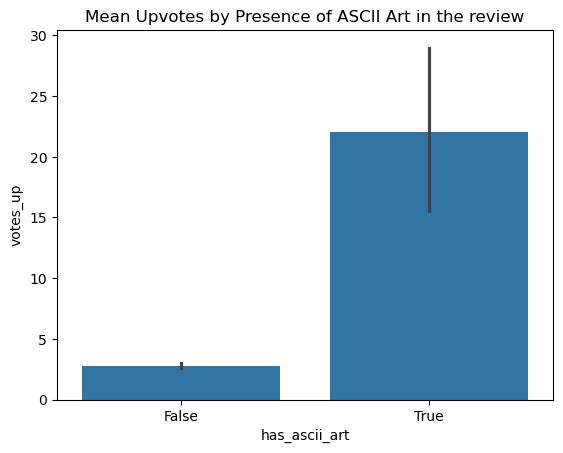

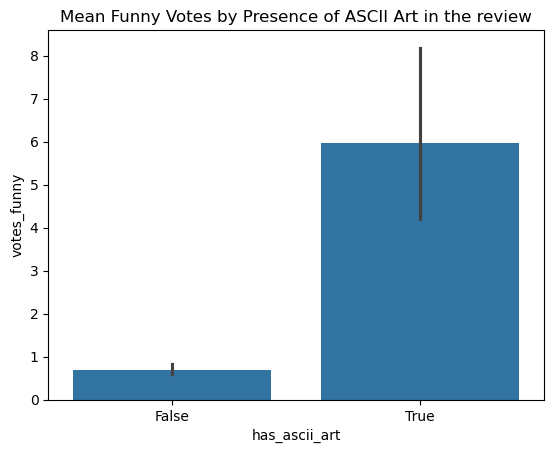

In [38]:
sns.barplot(x='has_ascii_art', y='votes_up', data=df, estimator=np.mean)
plt.title('Mean Upvotes by Presence of ASCII Art in the review')
plt.show()

sns.barplot(x='has_ascii_art', y='votes_funny', data=df, estimator=np.mean)
plt.title('Mean Funny Votes by Presence of ASCII Art in the review')
plt.show()